# 한국어 텍스트 감정 분석 - 데이터 전처리

이 노트북은 한국어 영화 리뷰 감정 분석을 위한 데이터 전처리 및 탐색적 데이터 분석(EDA)을 수행합니다.

## 주요 기능
- 데이터 품질 검사 및 정제
- 텍스트 전처리 파이프라인
- 훈련/검증 데이터 분할
- 전처리된 데이터 CSV 저장


### IMPORT

In [1]:
# 한국어 텍스트 감정 분석을 위한 필수 라이브러리들
from collections import Counter  # 카운터 자료구조
import os  # 운영체제 인터페이스
import platform  # 플랫폼 정보
import re  # 정규 표현식
import sys  # 시스템 정보
import warnings  # 경고 메시지 제어
import math


import matplotlib.pyplot as plt  # 데이터 시각화
plt.rc("font", family="NanumBarunGothic")  # 한글 폰트 설정(없으면 설치 필요)

import numpy as np  # 수치 연산
import pandas as pd  # 데이터 처리 및 분석
import seaborn as sns  # 고급 시각화
import torch  # 딥러닝 프레임워크
import koreanize_matplotlib
import wandb
# 머신러닝 관련 라이브러리
from sklearn.metrics import accuracy_score, f1_score  # 평가 지표
from sklearn.model_selection import train_test_split # 데이터 분할

# 트랜스포머 및 BERT 관련 라이브러리
from transformers import (
    AutoModelForSequenceClassification,  # 시퀀스 분류 모델
    AutoTokenizer,  # 토크나이저
    DataCollatorWithPadding,  # 패딩 데이터 콜레이터
    set_seed,
    Trainer,  # 트레이너
    TrainingArguments,  # 훈련 설정
)

# PyTorch 데이터 처리
from torch.utils.data import Dataset  # 데이터셋 및 데이터로더

# 경고 메시지 필터링
warnings.filterwarnings("ignore")

# 라이브러리 버전 정보 출력 (재현성을 위함)
print("=== 라이브러리 버전 정보 ===")
print(f"Python: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"torch: {torch.__version__}")
print(f"transformers: {__import__('transformers').__version__}")
print(f"sklearn: {__import__('sklearn').__version__}")
print(f"matplotlib: {__import__('matplotlib').__version__}")
print(f"seaborn: {sns.__version__}")

# GPU 사용 가능 여부 확인
print("\n=== PyTorch GPU 지원 정보 ===")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU 개수: {torch.cuda.device_count()}")
    print(f"현재 GPU: {torch.cuda.current_device()}")
    print(f"GPU 이름: {torch.cuda.get_device_name()}")
else:
    print("CPU에서 실행 중")


/data/ephemeral/home/py310/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotat

=== 라이브러리 버전 정보 ===
Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Platform: Linux-5.4.0-99-generic-x86_64-with-glibc2.31
pandas: 2.2.3
numpy: 1.26.4
torch: 2.6.0+cu124
transformers: 4.55.0
sklearn: 1.6.1
matplotlib: 3.10.5
seaborn: 0.13.2

=== PyTorch GPU 지원 정보 ===
CUDA 사용 가능: True
CUDA 버전: 12.4
GPU 개수: 1
현재 GPU: 0
GPU 이름: Tesla V100-SXM2-32GB


In [3]:
from dotenv import load_dotenv
import os

# 이 함수가 .env 파일을 읽어서 환경 변수로 로드합니다.
load_dotenv()


True

## Random Seed Configuration


In [4]:
# 랜덤 시드 설정
RANDOM_STATE = 42


set_seed(RANDOM_STATE)

print(f"랜덤 시드 {RANDOM_STATE}로 설정 완료")


랜덤 시드 42로 설정 완료


# Data Load


In [5]:
# 데이터 로드
df = pd.read_csv("data/train.csv")

# 처음 몇 행 표시
print("\n처음 5행:")
df.head()



처음 5행:


,ID,review,label,type
0,0,이 영화는 정말 여성의 강인함과 힘을 제대로 보여주는 작품이었어요! 주인공이 자기 ...,2,augment
1,1,어느 부잣집 도련님의 철없는 행각,1,original
2,3,왜이렇게 재미가없냐 원도 별로였지만 원보다 더 재미없네,0,original
3,4,크리스마스 시즌엔 무조건 홈 알론이죠! 맥컬리 컬킨이 연기한 케빈의 재치있고 천방지...,2,augment
4,5,참나ㅋㅋ이게 무슨 드라마 최초 뮤지컬드라마야 이게무슨ㅋㅋ걍 다른 드라마랑 똑같구만 ...,0,original


# EDA (Explanatory Data Analysis)


## 데이터 개요 및 품질 검사

- 데이터셋 형태 및 기본 정보
- 결측값
- 중복값
- 데이터 타입 확인


In [9]:
# 데이터셋 크기 및 기본 정보 확인
print(f"데이터셋 형태: {df.shape}")
print(f"행 수: {df.shape[0]}")
print(f"열 수: {df.shape[1]}")
print(f"열 이름: {list(df.columns)}")

# 타입별 데이터 분포 확인
print("\n타입별 데이터 분포:")
type_counts = df["type"].value_counts()
type_percentages = df["type"].value_counts(normalize=True) * 100
for type_name, count in type_counts.items():
    percentage = type_percentages[type_name]
    print(f"  {type_name}: {count:,}개 ({percentage:.1f}%)")

# 결측값 확인
print("\n결측값:")
print(df.isnull().sum())

# 중복값 확인
print(f"\n중복 리뷰: {df['review'].duplicated().sum()}")
print(f"중복 행: {df.duplicated().sum()}")

if df["review"].duplicated().sum() > 0:
    print("\n중복된 리뷰 예시:")
    duplicated_reviews = df[df["review"].duplicated(keep=False)].sort_values("review")
    print(duplicated_reviews[["review", "label", "type"]].head(10))

# 데이터 타입 확인
print("\n데이터 타입:")
print(df.dtypes)


데이터셋 형태: (279650, 4)
행 수: 279650
열 수: 4
열 이름: ['ID', 'review', 'label', 'type']

타입별 데이터 분포:
  augment: 139,825개 (50.0%)
  original: 139,825개 (50.0%)

결측값:
ID        0
review    6
label     0
type      0
dtype: int64

중복 리뷰: 3350
중복 행: 0

중복된 리뷰 예시:
       review  label      type
112658      !      2  original
197409      !      0  original
235169    -_-      0  original
85131     -_-      0  original
140661    -_-      0  original
35114       0      1  original
187569      0      1  original
159660     0점      0  original
217122     0점      0  original
209801     0점      0  original

데이터 타입:
ID         int64
review    object
label      int64
type      object
dtype: object


## 타입별 데이터 분석

- Original vs Augment 데이터 비교
- 타입별 클래스 분포
- 타입별 텍스트 특성 분석


In [10]:
# 타입별 상세 분석
print("=" * 50)
print("타입별 데이터 분석")
print("=" * 50)

# 타입별 기본 통계
for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    print(f"\n[{data_type.upper()} 데이터]")
    print(f"  총 개수: {len(type_data):,}개")
    print(f"  비율: {len(type_data)/len(df)*100:.1f}%")
    
    # 타입별 클래스 분포
    print(f"  클래스 분포:")
    type_class_counts = type_data["label"].value_counts().sort_index()
    type_class_percentages = type_data["label"].value_counts(normalize=True).sort_index() * 100
    for label, count in type_class_counts.items():
        percentage = type_class_percentages[label]
        print(f"    클래스 {label} ({LABEL_MAPPING[label]}): {count:,}개 ({percentage:.1f}%)")
    
    # 타입별 텍스트 길이 통계
    type_data["text_length"] = type_data["review"].str.len()
    type_data["word_count"] = type_data["review"].str.split().str.len()
    
    print(f"  텍스트 길이 통계:")
    print(f"    평균 문자 수: {type_data['text_length'].mean():.1f}")
    print(f"    평균 단어 수: {type_data['word_count'].mean():.1f}")
    print(f"    최대 문자 수: {type_data['text_length'].max()}")
    print(f"    최소 문자 수: {type_data['text_length'].min()}")

print("\n✅ 타입별 분석 완료")


타입별 데이터 분석

[AUGMENT 데이터]
  총 개수: 139,825개
  비율: 50.0%
  클래스 분포:
    클래스 0 (강한 부정): 57,033개 (40.8%)
    클래스 1 (약한 부정): 13,608개 (9.7%)
    클래스 2 (약한 긍정): 49,708개 (35.6%)
    클래스 3 (강한 긍정): 19,476개 (13.9%)
  텍스트 길이 통계:
    평균 문자 수: 282.0
    평균 단어 수: 69.9
    최대 문자 수: 2035
    최소 문자 수: 44

[ORIGINAL 데이터]
  총 개수: 139,825개
  비율: 50.0%
  클래스 분포:
    클래스 0 (강한 부정): 57,033개 (40.8%)
    클래스 1 (약한 부정): 13,608개 (9.7%)
    클래스 2 (약한 긍정): 49,708개 (35.6%)
    클래스 3 (강한 긍정): 19,476개 (13.9%)
  텍스트 길이 통계:
    평균 문자 수: 35.3
    평균 단어 수: 7.6
    최대 문자 수: 142.0
    최소 문자 수: 1.0

✅ 타입별 분석 완료


텍스트 길이 및 단어 수 컬럼 생성 중...
✅ 텍스트 길이 및 단어 수 컬럼 생성 완료


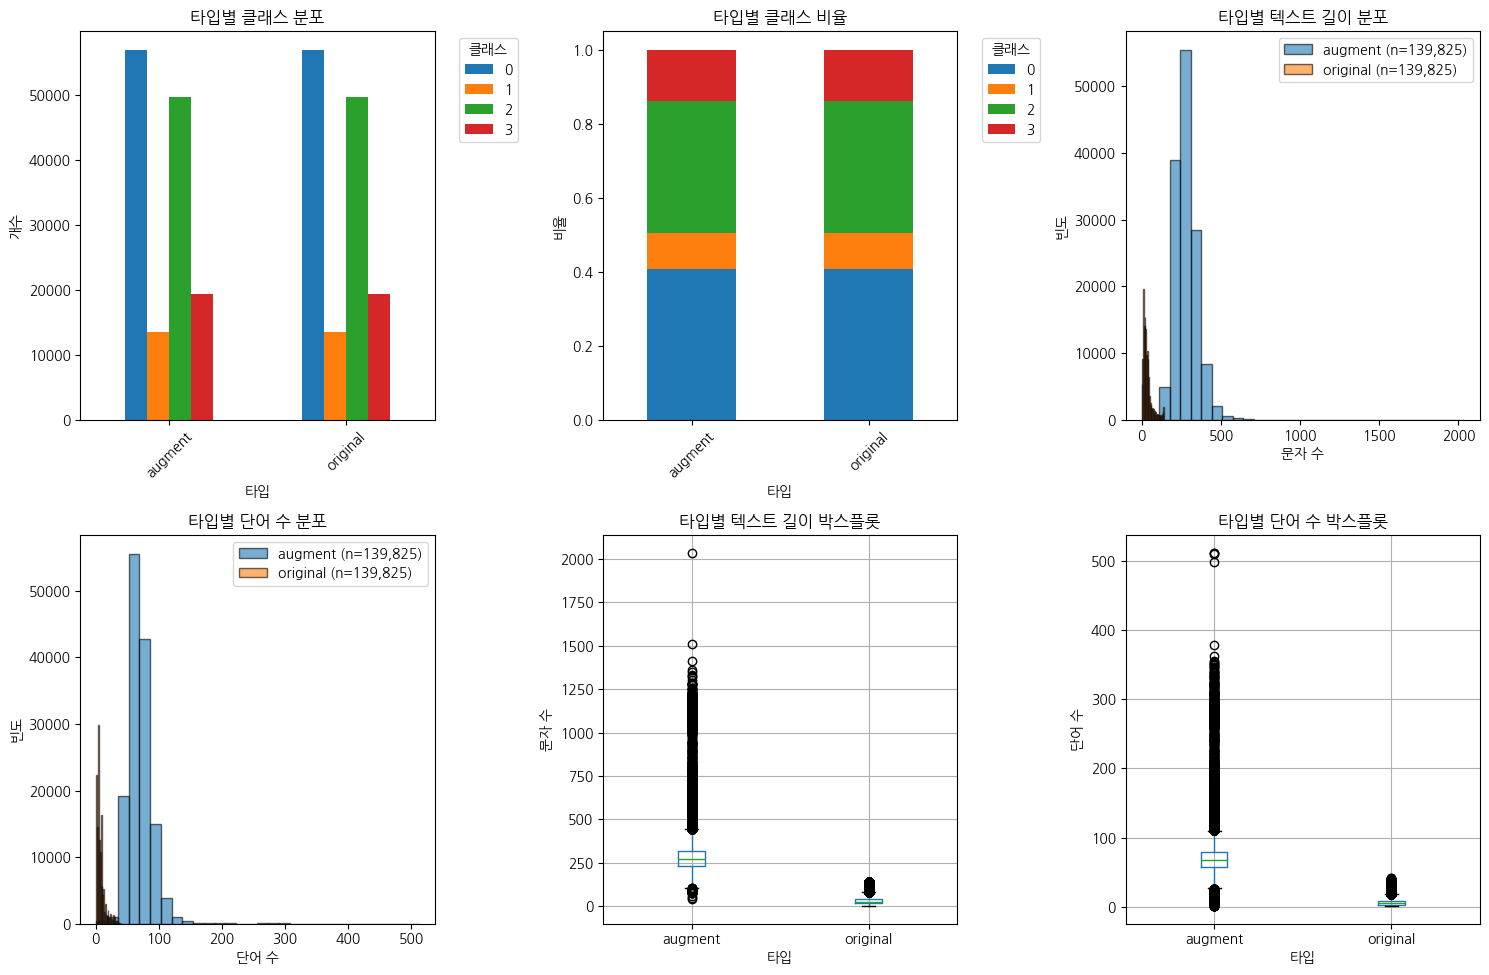

In [16]:
# 텍스트 길이 및 단어 수 컬럼 생성 (시각화를 위해)
print("텍스트 길이 및 단어 수 컬럼 생성 중...")
df["text_length"] = df["review"].str.len()
df["word_count"] = df["review"].str.split().str.len()
print("✅ 텍스트 길이 및 단어 수 컬럼 생성 완료")

# 타입별 시각화
plt.figure(figsize=(15, 10))

# 1. 타입별 클래스 분포 비교
plt.subplot(2, 3, 1)
type_class_pivot = df.groupby(['type', 'label']).size().unstack(fill_value=0)
type_class_pivot.plot(kind='bar', ax=plt.gca())
plt.title('타입별 클래스 분포')
plt.xlabel('타입')
plt.ylabel('개수')
plt.legend(title='클래스', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# 2. 타입별 클래스 비율 비교 (정규화)
plt.subplot(2, 3, 2)
type_class_pivot_norm = type_class_pivot.div(type_class_pivot.sum(axis=1), axis=0)
type_class_pivot_norm.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('타입별 클래스 비율')
plt.xlabel('타입')
plt.ylabel('비율')
plt.legend(title='클래스', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# 3. 타입별 텍스트 길이 분포
plt.subplot(2, 3, 3)
for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    plt.hist(type_data["text_length"], bins=30, alpha=0.6, 
             label=f"{data_type} (n={len(type_data):,})", edgecolor='black')
plt.title('타입별 텍스트 길이 분포')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.legend()

# 4. 타입별 단어 수 분포
plt.subplot(2, 3, 4)
for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    plt.hist(type_data["word_count"], bins=30, alpha=0.6, 
             label=f"{data_type} (n={len(type_data):,})", edgecolor='black')
plt.title('타입별 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.legend()

# 5. 타입별 텍스트 길이 박스플롯
plt.subplot(2, 3, 5)
df.boxplot(column='text_length', by='type', ax=plt.gca())
plt.title('타입별 텍스트 길이 박스플롯')
plt.xlabel('타입')
plt.ylabel('문자 수')
plt.suptitle('')  # 기본 제목 제거

# 6. 타입별 단어 수 박스플롯
plt.subplot(2, 3, 6)
df.boxplot(column='word_count', by='type', ax=plt.gca())
plt.title('타입별 단어 수 박스플롯')
plt.xlabel('타입')
plt.ylabel('단어 수')
plt.suptitle('')  # 기본 제목 제거

plt.tight_layout()
plt.show()


In [12]:
# 타입별 텍스트 품질 분석
print("=" * 50)
print("타입별 텍스트 품질 분석")
print("=" * 50)

for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    print(f"\n[{data_type.upper()} 데이터 품질 분석]")
    
    # 1. Null 값 및 빈 텍스트 확인
    null_count = type_data["review"].isnull().sum()
    empty_texts = type_data["review"].str.strip().eq("").sum()
    whitespace_only = type_data["review"].str.isspace().sum()
    
    print(f"  Null 값: {null_count}개")
    print(f"  빈 텍스트: {empty_texts}개")
    print(f"  공백만 있는 텍스트: {whitespace_only}개")
    
    # 2. 중복 텍스트 확인
    duplicate_count = type_data["review"].duplicated().sum()
    print(f"  중복 리뷰: {duplicate_count}개")
    
    # 3. 특수 문자만으로 구성된 텍스트 확인
    special_char_only = type_data["review"].str.match(r"^[^\w\s가-힣]+$", na=False).sum()
    print(f"  특수문자만 있는 리뷰: {special_char_only}개")
    
    # 4. 숫자만으로 구성된 텍스트 확인
    digit_only = type_data["review"].str.match(r"^\d+$", na=False).sum()
    print(f"  숫자만 있는 리뷰: {digit_only}개")
    
    # 5. 한글이 없는 텍스트 확인
    non_korean = ~type_data["review"].str.contains(r"[가-힣ㄱ-ㅎㅏ-ㅣ]", na=False)
    non_korean_count = non_korean.sum()
    print(f"  한글이 없는 리뷰: {non_korean_count}개")
    
    # 6. 품질 이슈 종합
    total_issues = null_count + empty_texts + whitespace_only + duplicate_count + special_char_only + digit_only + non_korean_count
    print(f"  총 품질 이슈: {total_issues:,}개 ({total_issues/len(type_data)*100:.2f}%)")
    print(f"  양질의 데이터: {len(type_data)-total_issues:,}개 ({(len(type_data)-total_issues)/len(type_data)*100:.2f}%)")

print("\n✅ 타입별 품질 분석 완료")


타입별 텍스트 품질 분석

[AUGMENT 데이터 품질 분석]
  Null 값: 0개
  빈 텍스트: 0개
  공백만 있는 텍스트: 0개
  중복 리뷰: 7개
  특수문자만 있는 리뷰: 0개
  숫자만 있는 리뷰: 0개
  한글이 없는 리뷰: 4개
  총 품질 이슈: 11개 (0.01%)
  양질의 데이터: 139,814개 (99.99%)

[ORIGINAL 데이터 품질 분석]
  Null 값: 6개
  빈 텍스트: 0개
  공백만 있는 텍스트: 0개
  중복 리뷰: 3343개
  특수문자만 있는 리뷰: 88개
  숫자만 있는 리뷰: 64개
  한글이 없는 리뷰: 1038개
  총 품질 이슈: 4,539개 (3.25%)
  양질의 데이터: 135,286개 (96.75%)

✅ 타입별 품질 분석 완료


In [13]:
# 타입별 샘플 리뷰 분석
print("=" * 50)
print("타입별 샘플 리뷰 분석")
print("=" * 50)

for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    print(f"\n[{data_type.upper()} 데이터 샘플 리뷰]")
    
    # 각 클래스별 샘플 리뷰
    for label in sorted(type_data["label"].unique()):
        print(f"\n  클래스 {label} ({LABEL_MAPPING[label]}) 샘플:")
        samples = type_data[type_data["label"] == label]["review"].head(2)
        for i, sample in enumerate(samples, 1):
            sample_preview = sample[:100] + "..." if len(sample) > 100 else sample
            print(f"    {i}. {sample_preview}")

print("\n✅ 타입별 샘플 리뷰 분석 완료")


타입별 샘플 리뷰 분석

[AUGMENT 데이터 샘플 리뷰]

  클래스 0 (강한 부정) 샘플:
    1. 진짜 이 영화 보다보면 내가 다 암 걸릴 듯. 등장인물들 하나같이 다 정신없고, 짜증나는 전개에 머리가 지끈지끈거려. 도대체 무슨 생각으로 이렇게 만들어놨는지 감독이 궁금할 정도야...
    2. 이 영화 진짜 20대인 내가 보기에도 너무 유치하고 질린다고 느껴졌어요. 스토리 전개도 너무 뻔하고, 예상 가능한 흐름이라서 보는 내내 하품이 나왔어요. 캐릭터들도 개성이 너무 없...

  클래스 1 (약한 부정) 샘플:
    1. 이 영화는 그냥 머리 식히면서 보면 괜찮을 것 같아요. 스토리나 액션 같은 건 별로 기대 안 하고 보면 그래도 나름 재밌는 요소들이 있긴 해요. 특히, 시각효과나 음악 같은 부분들...
    2. 음... 이 영화는 뭔가 계속 보다 보면 나도 모르게 분노가 차오르는 매력이 있긴 해요. 특히 잠이 안 올 때 보면 뭔가 시간을 잘 때울 수 있을 거 같아요. 하지만 전체적으로 보...

  클래스 2 (약한 긍정) 샘플:
    1. 이 영화는 정말 여성의 강인함과 힘을 제대로 보여주는 작품이었어요! 주인공이 자기 자신을 찾아가고, 가부장적인 사회 구조에 맞서는 모습이 너무 멋있었어요. 특히 마지막 장면에서 그...
    2. 크리스마스 시즌엔 무조건 홈 알론이죠! 맥컬리 컬킨이 연기한 케빈의 재치있고 천방지축인 모습을 보면서 웃음꽃이 피지 않은 이가 없을 거예요. 특히 그 두 명의 도둑들과의 에피소드들...

  클래스 3 (강한 긍정) 샘플:
    1. 와... 진짜 제대로 짱입니다 ㅡㅡ! 이 영화 하나로 한 주를 버틸 수 있을 것 같아요. 처음부터 끝까지 눈을 뗄 수가 없었어요. 특히 액션 장면은 진짜 소름 돋을 정도로 멋졌어요...
    2. 와, 이 영화 진짜 대박입니다! 노래 하나하나가 주옥같아서, 극장에서 나올 때까지 계속 흥얼거렸어요 ㅋㅋ 배우들 연기도 미쳤고요, 시대적 상황을 이렇게 잘 녹여낸 스토리에 완벽

In [15]:
# 타입별 데이터 분할 분석
print("=" * 50)
print("타입별 데이터 분할 분석")
print("=" * 50)

# 타입별 분할 전 분포 확인
print("분할 전 타입별 분포:")
for data_type in df["type"].unique():
    type_count = len(df[df["type"] == data_type])
    type_percentage = type_count / len(df) * 100
    print(f"  {data_type}: {type_count:,}개 ({type_percentage:.1f}%)")

print("\n✅ 타입별 분할 전 분석 완료")


타입별 데이터 분할 분석
분할 전 타입별 분포:
  augment: 139,825개 (50.0%)
  original: 139,825개 (50.0%)

✅ 타입별 분할 전 분석 완료


In [22]:
# 타입별 자주 등장하는 단어 빈도 분석
print("=" * 50)
print("타입별 자주 등장하는 단어 빈도 분석")
print("=" * 50)

from collections import Counter
import re

def extract_words(text):
    """텍스트에서 단어 추출 (한글, 영문, 숫자 포함)"""
    if pd.isna(text):
        return []
    # 한글, 영문, 숫자만 추출
    words = re.findall(r'[가-힣a-zA-Z0-9]+', str(text))
    return [word.lower() for word in words if len(word) > 1]  # 1글자 단어 제외

# 타입별 단어 빈도 분석
type_word_frequencies = {}

for data_type in df["type"].unique():
    print(f"\n[{data_type.upper()} 타입 단어 빈도 분석]")
    type_data = df[df["type"] == data_type]
    
    # 모든 텍스트에서 단어 추출
    all_words = []
    for text in type_data["review"]:
        words = extract_words(text)
        all_words.extend(words)
    
    # 단어 빈도 계산
    word_counter = Counter(all_words)
    type_word_frequencies[data_type] = word_counter
    
    print(f"  총 단어 수: {len(all_words):,}개")
    print(f"  고유 단어 수: {len(word_counter):,}개")
    print(f"  상위 20개 단어:")
    
    for i, (word, count) in enumerate(word_counter.most_common(20), 1):
        percentage = (count / len(all_words)) * 100
        print(f"    {i:2d}. {word:<15} {count:>6,}회 ({percentage:.2f}%)")

print("\n✅ 타입별 단어 빈도 분석 완료")


타입별 자주 등장하는 단어 빈도 분석

[AUGMENT 타입 단어 빈도 분석]
  총 단어 수: 8,477,733개
  고유 단어 수: 256,687개
  상위 20개 단어:
     1. 진짜              198,360회 (2.34%)
     2. 너무              182,486회 (2.15%)
     3. 정말              134,541회 (1.59%)
     4. 영화              113,322회 (1.34%)
     5. 보는              102,600회 (1.21%)
     6. 영화는             91,666회 (1.08%)
     7. 특히              82,235회 (0.97%)
     8. 보고              82,222회 (0.97%)
     9. 이런              79,408회 (0.94%)
    10. 내내              76,426회 (0.90%)
    11. 영화를             73,959회 (0.87%)
    12. 같아요             59,259회 (0.70%)
    13. 영화가             47,530회 (0.56%)
    14. 배우들의            44,253회 (0.52%)
    15. 그냥              40,905회 (0.48%)
    16. 전혀              34,161회 (0.40%)
    17. 완전              32,437회 (0.38%)
    18. 보면서             31,223회 (0.37%)
    19. 연기도             30,851회 (0.36%)
    20. 정도로             30,244회 (0.36%)

[ORIGINAL 타입 단어 빈도 분석]
  총 단어 수: 1,010,525개
  고유 단어 수: 273,801개
  상위 20개 단어:
     1. 영화         

In [24]:
# 타입별 단어 사용 패턴 차이점 상세 분석
print("=" * 50)
print("타입별 단어 사용 패턴 차이점 상세 분석")
print("=" * 50)

# 1. 단어 다양성 지표 계산
def calculate_diversity_metrics(word_counter, total_words):
    """단어 다양성 지표 계산"""
    unique_words = len(word_counter)
    total_words = sum(word_counter.values())
    
    # 1) Type-Token Ratio (TTR)
    ttr = unique_words / total_words if total_words > 0 else 0
    
    # 2) Simpson's Diversity Index
    simpson = sum((count / total_words) ** 2 for count in word_counter.values()) if total_words > 0 else 0
    simpson_diversity = 1 - simpson
    
    # 3) Shannon Entropy
    entropy = 0
    for count in word_counter.values():
        if count > 0:
            p = count / total_words
            entropy -= p * np.log2(p)
    
    return {
        'unique_words': unique_words,
        'total_words': total_words,
        'ttr': ttr,
        'simpson_diversity': simpson_diversity,
        'shannon_entropy': entropy
    }

# 각 타입별 다양성 지표 계산
diversity_metrics = {}
for data_type in ['original', 'augment']:
    word_counter = type_word_frequencies[data_type]
    total_words = sum(word_counter.values())
    diversity_metrics[data_type] = calculate_diversity_metrics(word_counter, total_words)

print("단어 다양성 지표:")
print(f"{'지표':<20} {'Original':<15} {'Augment':<15} {'차이':<15}")
print("-" * 65)

for metric in ['unique_words', 'total_words', 'ttr', 'simpson_diversity', 'shannon_entropy']:
    orig_val = diversity_metrics['original'][metric]
    aug_val = diversity_metrics['augment'][metric]
    diff = aug_val - orig_val
    print(f"{metric:<20} {orig_val:<15.4f} {aug_val:<15.4f} {diff:<15.4f}")

# 2. 감정 관련 단어 분석
emotion_words = {
    'positive': ['좋다', '좋은', '좋아', '재미', '재밌', '재미있', '최고', '훌륭', '멋있', '사랑', '행복', '기쁘', '만족', '감동'],
    'negative': ['나쁘', '싫', '최악', '별로', '재미없', '지루', '짜증', '화나', '슬프', '실망', '후회', '괴롭', '힘들', '어렵'],
    'intensifier': ['정말', '진짜', '완전', '너무', '엄청', '대박', '개', '존나', '미친', '쩔어', '대단', '굉장']
}

print(f"\n감정 관련 단어 분석:")
print(f"{'카테고리':<15} {'단어':<20} {'Original':<10} {'Augment':<10} {'비율차이':<10}")
print("-" * 70)

for category, words in emotion_words.items():
    for word in words:
        orig_count = type_word_frequencies['original'].get(word, 0)
        aug_count = type_word_frequencies['augment'].get(word, 0)
        
        orig_total = diversity_metrics['original']['total_words']
        aug_total = diversity_metrics['augment']['total_words']
        
        orig_ratio = (orig_count / orig_total) * 100 if orig_total > 0 else 0
        aug_ratio = (aug_count / aug_total) * 100 if aug_total > 0 else 0
        ratio_diff = aug_ratio - orig_ratio
        
        if orig_count > 0 or aug_count > 0:  # 한 타입이라도 나타나는 단어만 출력
            print(f"{category:<15} {word:<20} {orig_count:<10} {aug_count:<10} {ratio_diff:<10.4f}")

# 3. 단어 길이 분포 분석
def analyze_word_length_distribution(word_counter):
    """단어 길이별 분포 분석"""
    length_dist = {}
    for word, count in word_counter.items():
        length = len(word)
        if length not in length_dist:
            length_dist[length] = 0
        length_dist[length] += count
    return length_dist

print(f"\n단어 길이별 분포:")
print(f"{'길이':<8} {'Original':<15} {'Augment':<15} {'Original%':<12} {'Augment%':<12}")
print("-" * 70)

orig_length_dist = analyze_word_length_distribution(type_word_frequencies['original'])
aug_length_dist = analyze_word_length_distribution(type_word_frequencies['augment'])

all_lengths = set(orig_length_dist.keys()) | set(aug_length_dist.keys())
orig_total = sum(orig_length_dist.values())
aug_total = sum(aug_length_dist.values())

for length in sorted(all_lengths):
    orig_count = orig_length_dist.get(length, 0)
    aug_count = aug_length_dist.get(length, 0)
    orig_pct = (orig_count / orig_total) * 100 if orig_total > 0 else 0
    aug_pct = (aug_count / aug_total) * 100 if aug_total > 0 else 0
    print(f"{length:<8} {orig_count:<15} {aug_count:<15} {orig_pct:<12.2f} {aug_pct:<12.2f}")

print("\n✅ 타입별 단어 사용 패턴 차이점 분석 완료")


타입별 단어 사용 패턴 차이점 상세 분석
단어 다양성 지표:
지표                   Original        Augment         차이             
-----------------------------------------------------------------
unique_words         273801.0000     256687.0000     -17114.0000    
total_words          1010525.0000    8477733.0000    7467208.0000   
ttr                  0.2709          0.0303          -0.2407        
simpson_diversity    0.9993          0.9972          -0.0021        
shannon_entropy      15.0227         11.8434         -3.1794        

감정 관련 단어 분석:
카테고리            단어                   Original   Augment    비율차이      
----------------------------------------------------------------------
positive        좋다                   838        111        -0.0816   
positive        좋은                   1619       15282      0.0200    
positive        좋아                   206        732        -0.0118   
positive        재미                   797        720        -0.0704   
positive        재밌                   6          0  

In [ ]:
# 클래스별 어휘 다양성 분석
print("\n클래스별 어휘 다양성:")
for class_name in sorted(df["label"].unique()):
    class_data = df[df["label"] == class_name]
    # 클래스별 전체 텍스트 결합
    all_text = " ".join(class_data["review"].astype(str))
    words = all_text.split()
    unique_words = set(words)

    # Type-Token Ratio (어휘 다양성 지표)
    ttr = len(unique_words) / len(words) if len(words) > 0 else 0

    print(
        f"  {class_name} ({LABEL_MAPPING[class_name]}): 총 단어 {len(words)}개, 고유 단어 {len(unique_words)}개, TTR: {ttr:.3f}"
    )

## 타겟 변수 분석

- 클래스 분포 확인
- 데이터 불균형 확인


In [ ]:
# 타입별 및 클래스별 어휘 다양성 분석
print("=" * 50)
print("어휘 다양성 분석")
print("=" * 50)

# 1. 타입별 어휘 다양성
print("\n타입별 어휘 다양성:")
for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    # 타입별 전체 텍스트 결합
    all_text = " ".join(type_data["review"].astype(str))
    words = all_text.split()
    unique_words = set(words)

    # Type-Token Ratio (어휘 다양성 지표)
    ttr = len(unique_words) / len(words) if len(words) > 0 else 0

    print(
        f"  {data_type}: 총 단어 {len(words):,}개, 고유 단어 {len(unique_words):,}개, TTR: {ttr:.3f}"
    )

# 2. 클래스별 어휘 다양성
print("\n클래스별 어휘 다양성:")
for class_name in sorted(df["label"].unique()):
    class_data = df[df["label"] == class_name]
    # 클래스별 전체 텍스트 결합
    all_text = " ".join(class_data["review"].astype(str))
    words = all_text.split()
    unique_words = set(words)

    # Type-Token Ratio (어휘 다양성 지표)
    ttr = len(unique_words) / len(words) if len(words) > 0 else 0

    print(
        f"  {class_name} ({LABEL_MAPPING[class_name]}): 총 단어 {len(words):,}개, 고유 단어 {len(unique_words):,}개, TTR: {ttr:.3f}"
    )

# 3. 타입별 클래스별 어휘 다양성 (교차 분석)
print("\n타입별 클래스별 어휘 다양성 (교차 분석):")
for data_type in df["type"].unique():
    print(f"\n[{data_type.upper()} 타입]")
    type_data = df[df["type"] == data_type]
    
    for class_name in sorted(type_data["label"].unique()):
        class_type_data = type_data[type_data["label"] == class_name]
        # 타입-클래스별 전체 텍스트 결합
        all_text = " ".join(class_type_data["review"].astype(str))
        words = all_text.split()
        unique_words = set(words)

        # Type-Token Ratio (어휘 다양성 지표)
        ttr = len(unique_words) / len(words) if len(words) > 0 else 0

        print(
            f"    클래스 {class_name} ({LABEL_MAPPING[class_name]}): 총 단어 {len(words):,}개, 고유 단어 {len(unique_words):,}개, TTR: {ttr:.3f}"
        )

print("\n✅ 어휘 다양성 분석 완료")


In [18]:
# 라벨 매핑 정의
LABEL_MAPPING = {0: "강한 부정", 1: "약한 부정", 2: "약한 긍정", 3: "강한 긍정"}


In [19]:
# 클래스 분포 분석
class_counts = df["label"].value_counts()
class_percentages = df["label"].value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_counts)
print("\nClass percentages:")
for label, percentage in class_percentages.items():
    print(f"{label} ({LABEL_MAPPING[label]}): {percentage:.2f}%")

# 클래스 불균형 체크
imbalance_ratio = class_percentages.max() / class_percentages.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")
print("⚠️ Imbalanced" if imbalance_ratio > 3 else "✅ Balanced")


Class Distribution:
label
0    114066
2     99416
3     38952
1     27216
Name: count, dtype: int64

Class percentages:
0 (강한 부정): 40.79%
2 (약한 긍정): 35.55%
3 (강한 긍정): 13.93%
1 (약한 부정): 9.73%

Imbalance ratio: 4.19
⚠️ Imbalanced


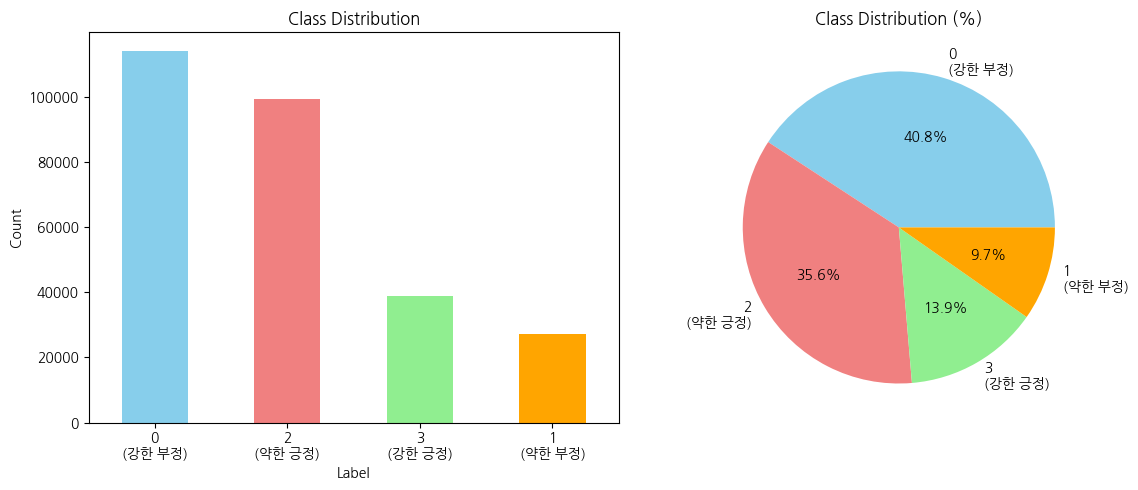

In [20]:
# 시각화
plt.figure(figsize=(12, 5))
colors = ["skyblue", "lightcoral", "lightgreen", "orange"]

plt.subplot(1, 2, 1)
class_counts.plot(kind="bar", color=colors[: len(class_counts)])
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
# Add label mapping to x-axis
ax = plt.gca()
ax.set_xticklabels(
    [f"{label}\n({LABEL_MAPPING[label]})" for label in class_counts.index]
)

plt.subplot(1, 2, 2)
pie_labels = [f"{label}\n({LABEL_MAPPING[label]})" for label in class_counts.index]
plt.pie(
    class_counts.values,
    labels=pie_labels,
    autopct="%1.1f%%",
    colors=colors[: len(class_counts)],
)
plt.title("Class Distribution (%)")

plt.tight_layout()
plt.show()


## 입력 변수 분석

- 텍스트 길이 확인
- 이상치 탐지


In [ ]:
# 텍스트 길이 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df["text_length"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.title("문자 수 분포")
plt.xlabel("문자 수")
plt.ylabel("빈도")
plt.axvline(
    df["text_length"].mean(),
    color="red",
    linestyle="--",
    label=f"평균: {df['text_length'].mean():.1f}",
)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df["word_count"], bins=50, alpha=0.7, color="lightcoral", edgecolor="black")
plt.title("단어 수 분포")
plt.xlabel("단어 수")
plt.ylabel("빈도")
plt.axvline(
    df["word_count"].mean(),
    color="red",
    linestyle="--",
    label=f"평균: {df['word_count'].mean():.1f}",
)
plt.legend()

plt.tight_layout()
plt.show()


# Data/Feature Engineering


In [ ]:
# 데이터 전처리를 위한 복사본 생성
df_processed = df[["ID", "label", "review"]].copy()

print(f"원본 데이터셋 크기: {len(df_processed):,}개")

df_processed.head()


In [ ]:
def clean_data_quality(df, text_col='review', label_col='label', id_col='ID'):
    """
    데이터 품질 검사 및 문제가 있는 데이터 제거
    
    Args:
        df: 원본 데이터프레임
        text_col: 텍스트 컬럼명
        label_col: 라벨 컬럼명  
        id_col: ID 컬럼명
    
    Returns:
        clean_df: 품질 문제가 제거된 데이터프레임
        removed_info: 제거된 데이터 정보
    """
    print(f"원본 데이터 수: {len(df):,}개")
    
    # 1. 품질 검사
    null_mask = df[text_col].isnull()
    empty_mask = df[text_col].str.strip().eq("")
    whitespace_mask = df[text_col].str.isspace()
    duplicate_mask = df[text_col].duplicated()
    digit_only_mask = df[text_col].str.match(r"^\d+$", na=False)
    
    print(f"Null 값: {null_mask.sum()}개")
    print(f"빈 텍스트: {empty_mask.sum()}개") 
    print(f"공백만 있는 텍스트: {whitespace_mask.sum()}개")
    print(f"중복 리뷰: {duplicate_mask.sum()}개")
    print(f"숫자만 있는 리뷰: {digit_only_mask.sum()}개")
    
    # 2. 품질 문제가 있는 데이터 마스크 생성
    quality_issues_mask = (
        null_mask | 
        empty_mask | 
        whitespace_mask | 
        duplicate_mask | 
        digit_only_mask 
    )
    
    # 3. 품질 문제가 있는 데이터 제거
    clean_df = df[~quality_issues_mask].copy().reset_index(drop=True)
    removed_count = quality_issues_mask.sum()
    
    print(f"\n=== 데이터 품질 검사 결과 ===")
    print(f"제거된 데이터: {removed_count:,}개")
    print(f"남은 데이터: {len(clean_df):,}개")
    print(f"데이터 품질 비율: {len(clean_df) / len(df) * 100:.2f}%")
    
    # 4. 제거된 데이터의 상세 정보 출력
    if removed_count > 0:
        print(f"\n=== 제거된 데이터 상세 정보 ===")
        removed_data = df[quality_issues_mask]
        
        if null_mask.sum() > 0:
            print(f"Null 값 샘플: {removed_data[null_mask][text_col].head(3).tolist()}")
        if empty_mask.sum() > 0:
            print(f"빈 텍스트 샘플: {removed_data[empty_mask][text_col].head(3).tolist()}")
        if whitespace_mask.sum() > 0:
            print(f"공백만 있는 텍스트 샘플: {removed_data[whitespace_mask][text_col].head(3).tolist()}")
        if duplicate_mask.sum() > 0:
            print(f"중복 리뷰 샘플: {removed_data[duplicate_mask][text_col].head(3).tolist()}")
        if digit_only_mask.sum() > 0:
            print(f"숫자만 있는 리뷰 샘플: {removed_data[digit_only_mask][text_col].head(3).tolist()}")
    
    # 5. 제거된 데이터 정보 저장
    removed_info = {
        'total_removed': removed_count,
        'null_count': null_mask.sum(),
        'empty_count': empty_mask.sum(),
        'whitespace_count': whitespace_mask.sum(),
        'duplicate_count': duplicate_mask.sum(),
        'digit_only_count': digit_only_mask.sum()
    }
    
    return clean_df, removed_info

print("✅ 데이터 품질 검사 및 제거 함수 정의 완료")


In [ ]:
# 텍스트 전처리 파이프라인 클래스 구성
class TextPreprocessingPipeline:
    """
    텍스트 전처리 파이프라인 클래스
    - 기본 전처리와 학습 데이터 기반 고급 전처리를 통합 관리
    - 재사용 가능하고 확장 가능한 구조
    """

    def __init__(self):
        self.is_fitted = False
        self.vocab_info = {}
        self.label_patterns = {}

    def basic_preprocess(self, texts):
        """기본 전처리 (clean_text + normalize 기능)"""
        processed_texts = []
        for text in texts:
            # 기본 텍스트 정리
            cleaned = self._clean_text(text)
            processed_texts.append(cleaned)
        return processed_texts

    def _clean_text(self, text):
        """기존 clean_text 함수 내용"""
        if pd.isna(text):
            return ""

        text = str(text).strip()
        text = text.lower() # 소문자 변환
        text = self._remove_urls_emails_mentions(text) # URL, 이메일, 멘션 제거
        text = self._normalize_punctuation(text)  # 구두점 정규화
        #text = self._remove_incomplete_korean(text)
        text = self._normalize_emotion_expressions(text) # 감정 표현 정규화 (ㅋㅋㅋ , ㅎㅎㅎ)
        text = self._reduce_excessive_repetition(text) # 과도한 문자 반복 축소 (아아아아아아앙 -> 아아아아)
        text = self._clean_special_characters(text) # 특수문자 제거 (이모티콘, 특수기호)
        text = self._normalize_whitespace(text) # 공백 정규화 (여러 개의 공백 -> 하나의 공백)

        return text.strip()

    def fit(self, texts, labels=None):
        """학습 데이터로부터 전처리 정보 학습 (품질 검사 기준 학습)"""

        self.is_fitted = True
        print("✓ 전처리 파이프라인 학습 완료")


    def transform(self, texts):
        """전처리 적용 (품질 문제 데이터 제거 + 텍스트 전처리)"""
        if not self.is_fitted:
            print(
                "Warning: 파이프라인이 학습되지 않았습니다. 기본 전처리만 적용합니다."
            )
            return self.basic_preprocess(texts)
        
        # 텍스트 전처리 적용
        return self.basic_preprocess(texts)

    def fit_transform(self, texts, labels=None):
        """학습과 변환을 동시에 수행"""
        # 1. 학습 단계 (품질 검사 기준 학습)
        self.fit(texts, labels)
        
        # 2. 변환 단계 (품질 문제 데이터 제거 + 텍스트 전처리)
        processed_texts = self.transform(texts)
        
        # 3. 라벨도 동일하게 필터링
        return processed_texts


    @staticmethod
    def _remove_incomplete_korean(text):
        """불완전한 한글 제거 (자음/모음만 있는 경우)"""
        return re.sub(r"[ㄱ-ㅎㅏ-ㅣ]+", "", text)

    @staticmethod
    def _normalize_emotion_expressions(text):
        """감정 표현 정규화"""
        def replace_emotion(match):
            char = match.group(1)
            count = len(match.group(0))
            # log2x + 1 공식을 정수로 변환
            new_count = int(math.log2(count)) + 1 if count > 0 else 1
            return char * new_count
        
        # 웃음과 슬픔 표현 정규화 (2번 이상 반복)
        text = re.sub(r"([ㅋㅎ])\1+", replace_emotion, text)
        text = re.sub(r"([ㅠㅜㅡ])\1+", replace_emotion, text)
        return text

    @staticmethod
    def _reduce_excessive_repetition(text):
        """과도한 문자 반복 축소 (4번 이상 → 3번으로)"""
        
        def replace_repetition(match):
            char = match.group(1)
            count = len(match.group(0))
            # log2x + 1 공식을 정수로 변환하고 최소 1개 보장
            new_count = max(1, int(math.log2(count)) + 1) if count > 0 else 1
            return char * new_count
        
        return re.sub(r"(.)\1{3,}", replace_repetition, text)

    @staticmethod
    def _clean_special_characters(text):
        """특수문자 제거 (이모티콘 보존)"""

        # 1. 허용할 이모티콘 범위 정의
        # emoji_ranges = r"\U0001F600-\U0001F64F"  # Emoticons
        # emoji_ranges += r"\U0001F300-\U0001F5FF"  # Misc Symbols/Pictographs
        # emoji_ranges += r"\U0001F680-\U0001F6FF"  # Transport/Map
        # emoji_ranges += r"\U00002600-\U000026FF"  # Misc Symbols (★ 포함)
        # emoji_ranges += r"\U00002700-\U000027BF"  # Dingbats

        # 2. 허용할 기타 특수기호 정의
        other_symbols = r"@★#$" # 예시로 @ 추가

        # 3. 허용할 문자들을 조합하여 정규식 생성
        #allowed_chars = rf"\w\s가-힣.,!?ㅋㅎㅠㅜㅡ~\-{emoji_ranges}{other_symbols}"
        allowed_chars = rf"\w\s가-힣.,!?ㅋㅎㅠㅜㅡ~\-"
        
        return re.sub(rf"[^{allowed_chars}]", " ", text)
 
 
    @staticmethod
    def _normalize_whitespace(text):
        """공백 정규화"""
        return re.sub(r"\s+", " ", text)

    @staticmethod
    def _normalize_punctuation(text):
        """구두점 정규화 (log 공식 적용)"""
        def replace_punctuation(match):
            char = match.group(1)
            count = len(match.group(0))
            # log2x + 1 공식을 정수로 변환
            new_count = int(math.log2(count)) + 1 if count > 0 else 1
            return char * new_count
        
        # 각 구두점별로 log 공식 적용
        text = re.sub(r"([.])\1+", replace_punctuation, text)
        text = re.sub(r"([!])\1+", replace_punctuation, text)
        text = re.sub(r"([?])\1+", replace_punctuation, text)
        text = re.sub(r"([,])\1+", replace_punctuation, text)
        
        # 구두점 앞뒤 공백 정리
        text = re.sub(r"\s+([.,!?])", r"\1", text)
        text = re.sub(r"([.,!?])\s+", r"\1 ", text)
        
        return text

    @staticmethod
    def _remove_urls_emails_mentions(text):
        """URL, 이메일, 멘션 제거"""
        # URL 패턴 제거
        text = re.sub(
            r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
            "",
            text,
        )
        # 이메일 패턴 제거
        text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", "", text)
        # 멘션 패턴 제거
        text = re.sub(r"\B@\w+", "", text)
        
        return text


In [ ]:
preprocessor = TextPreprocessingPipeline()


## 데이터 분할 전략

- 훈련/검증 데이터 분할
- 클래스 분포를 유지하는 계층적 분할


In [ ]:
# 데이터 품질 검사 및 제거
df_clean, removed_info = clean_data_quality(df_processed)

print(f"\n원본 데이터: {len(df_processed):,}개")
print(f"정제된 데이터: {len(df_clean):,}개")
print(f"제거된 데이터: {removed_info['total_removed']:,}개")


In [ ]:
# 데이터 분할 - 텍스트 전처리 파이프라인 적용
X = df_clean["review"]  # 원본 텍스트 데이터 사용 (파이프라인에서 전처리 수행)
y = df_clean["label"]
ids = df_clean["ID"]

# 훈련/검증 데이터 분할 (train 80%, val 20%) - 계층 분할로 클래스 분포 유지
X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
    X, y, ids, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"전체 데이터: {len(X):,}개")
print(f"훈련 데이터: {len(X_train):,}개")
print(f"검증 데이터: {len(X_val):,}개")

# 텍스트 전처리 파이프라인 적용
print("훈련 데이터에 대한 전처리 파이프라인 학습 및 적용...")
X_train_processed = preprocessor.fit_transform(X_train.tolist(), y_train.tolist())

print("검증 데이터에 전처리 파이프라인 적용...")
X_val_processed = preprocessor.transform(X_val.tolist())

# 원본 데이터프레임 구조로 분할된 데이터 생성 - 모델 학습용 형태
train_data = pd.DataFrame(
    {"ID": ids_train, "review": X_train_processed, "label": y_train}
).reset_index(drop=True)

val_data = pd.DataFrame(
    {"ID": ids_val, "review": X_val_processed, "label": y_val}
).reset_index(drop=True)

print(f"\nTrain: {len(train_data)}, Val: {len(val_data)}")

# 계층 분할이 올바르게 수행되었는지 검증 - 클래스 분포 확인
print("\n클래스 분포 검증:")
print("원본 데이터:")
original_distribution = y.value_counts(normalize=True).sort_index()
original_counts = y.value_counts().sort_index()
for idx, val in original_distribution.items():
    count = original_counts[idx]
    print(f"  클래스 {idx}: {count}개 ({val * 100:.1f}%)")

print("\n훈련 데이터:")
train_distribution = train_data["label"].value_counts(normalize=True).sort_index()
train_counts = train_data["label"].value_counts().sort_index()
for idx, val in train_distribution.items():
    count = train_counts[idx]
    print(f"  클래스 {idx}: {count}개 ({val * 100:.1f}%)")

print("\n검증 데이터:")
val_distribution = val_data["label"].value_counts(normalize=True).sort_index()
val_counts = val_data["label"].value_counts().sort_index()
for idx, val in val_distribution.items():
    count = val_counts[idx]
    print(f"  클래스 {idx}: {count}개 ({val * 100:.1f}%)")

# 전처리 결과 확인
print("\n전처리 결과 샘플:")
for i in range(3):
    print(f"원본: {X_train.iloc[i]}")
    print(f"전처리: {X_train_processed[i]}")
    print()


# 데이터 저장

전처리된 데이터를 CSV 파일로 저장하여 모델 학습 노트북에서 사용할 수 있도록 합니다.


In [ ]:
# 전처리된 데이터를 CSV 파일로 저장
import os

# data 디렉토리가 없으면 생성
os.makedirs("data", exist_ok=True)

# 훈련 데이터 저장
train_data.to_csv("data/train_processed.csv", index=False)
print(f"✅ 훈련 데이터 저장 완료: data/train_processed.csv ({len(train_data):,}개)")

# 검증 데이터 저장
val_data.to_csv("data/val_processed.csv", index=False)
print(f"✅ 검증 데이터 저장 완료: data/val_processed.csv ({len(val_data):,}개)")

# 전처리 파이프라인 정보 저장 (선택사항)
preprocessing_info = {
    'total_original_samples': len(df),
    'total_clean_samples': len(df_clean),
    'removed_samples': removed_info['total_removed'],
    'train_samples': len(train_data),
    'val_samples': len(val_data),
    'preprocessing_pipeline_fitted': preprocessor.is_fitted
}

print(f"\n=== 전처리 완료 요약 ===")
print(f"원본 데이터: {preprocessing_info['total_original_samples']:,}개")
print(f"품질 검사 후: {preprocessing_info['total_clean_samples']:,}개")
print(f"제거된 데이터: {preprocessing_info['removed_samples']:,}개")
print(f"훈련 데이터: {preprocessing_info['train_samples']:,}개")
print(f"검증 데이터: {preprocessing_info['val_samples']:,}개")
print(f"전처리 파이프라인 학습 완료: {preprocessing_info['preprocessing_pipeline_fitted']}")

print(f"\n✅ 전처리 완료! 다음 단계: train_pytorch.ipynb에서 모델 학습을 진행하세요.")
